In [1]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import uproot 
import awkward as ak
from pathlib import Path

from typing import Dict, List 
import re
import pickle

In [2]:
npy_file_path = '/global/cfs/projectdirs/atlas/hrzhao/qgcal/BDT_EPEML/perpared_dijets/Processed_Samples_Pythia_Nov8/periodA/dijet_pythia_mc16A.npy'
npy_file_path = Path(npy_file_path)

In [3]:
with open(npy_file_path, 'rb') as f:
    dijet = np.load(f, allow_pickle=True)

In [4]:
len(dijet)

252

In [5]:
dijet[0] # from the first file 

array([[[ 7.66747925e+02,  1.29866242e+00,  2.00000000e+00,
          3.18291754e-01,  2.15923324e-01, -1.92873359e-01,
          2.10000000e+01,  1.76094341e+01],
        [ 7.01621765e+02, -9.89430845e-01,  2.00000000e+00,
          2.69897908e-01,  1.57799199e-01, -1.26820713e-01,
         -1.00000000e+00,  1.76094341e+01]]])

In [6]:
dijet_all_array = np.array(dijet)
dijet_all_event = np.concatenate(dijet_all_array, axis=0)

In [7]:
jets = np.concatenate(dijet_all_event, axis=0)

In [8]:
all_jets = jets[jets[:, 7] != 0 ] # remove event with weight 0 

In [9]:
all_jets.shape

(56414516, 8)

In [10]:
quark_idx = np.where((all_jets[:,6]==1) | (all_jets[:,6]==2) | (all_jets[:,6]==3) | (all_jets[:,6]==4) | (all_jets[:,6]==5))
quark_jet = all_jets[quark_idx]

gluon_idx = np.where((all_jets[:,6]==21))
gluon_jet = all_jets[gluon_idx]

In [11]:
len(quark_jet)

31988293

In [12]:
len(gluon_jet)

24424285

# 10k sample

In [19]:
nevents = 10000

rng = np.random.default_rng(seed=567)
selected_quark = rng.choice(quark_jet, nevents)
selected_gluon = rng.choice(gluon_jet, nevents)

X = np.concatenate((selected_quark, selected_gluon), axis=0)
y = np.concatenate((np.zeros(nevents), 1.0 * np.ones(nevents))) # quark with label 0 and gluon with label one 
assert X.shape == (2 * nevents,8)

import pandas as pd 
branch_names = ["jet_pt", "jet_eta", "jet_nTracks", "jet_trackWidth", "jet_trackC1", "jet_trackBDT", "jet_PartonTruthLabelID", "total_weight"]

small_sample = pd.DataFrame(np.concatenate((X, y[:,None]), axis = 1), columns = branch_names + ["target"])
small_sample.to_pickle("../pkls/sample_10k.pkl")


# 100k samples 

In [23]:
X = np.concatenate((quark_jet, gluon_jet), axis=0)
y = np.concatenate((np.zeros(len(quark_jet)), 1.0 * np.zeros(len(gluon_jet)))) # quark with label 0 and gluon with label one 

assert X.shape == (len(quark_jet) + len(gluon_jet),8)

import pandas as pd 
branch_names = ["jet_pt", "jet_eta", "jet_nTracks", "jet_trackWidth", "jet_trackC1", "jet_trackBDT", "jet_PartonTruthLabelID", "total_weight"]

all_sample = pd.DataFrame(np.concatenate((X, y[:,None]), axis = 1), columns = branch_names + ["target"])
all_sample.to_pickle("../pkls/sample_all.pkl")



# All jets

In [ ]:
nevents = 10000

selected_quark = rng.choice(quark_jet, nevents)
selected_gluon = rng.choice(gluon_jet, nevents)

X = np.concatenate((selected_quark, selected_gluon), axis=0)
y = np.concatenate((np.zeros(nevents), 1.0 * np.ones(nevents))) # quark with label 0 and gluon with label one 
assert X.shape == (2 * nevents,8)

import pandas as pd 
branch_names = ["jet_pt", "jet_eta", "jet_nTracks", "jet_trackWidth", "jet_trackC1", "jet_trackBDT", "jet_PartonTruthLabelID", "total_weight"]

small_sample = pd.DataFrame(np.concatenate((X, y[:,None]), axis = 1), columns = branch_names + ["target"])
small_sample.to_pickle("../pkls/sample_10k.pkl")


In [77]:
def draw_pt_spectrum(pt_array, bins, user_weights = None, title = ' ', use_log = True, save = False):
    fig, ax = plt.subplots()
    if user_weights is None:
        ax.hist(pt_array, bins)
    else:
        ax.hist(pt_array, bins, weights = user_weights)
    ax.set_title(title + '$p_{T}$ Spectrum')
    ax.set_xlabel('Jet $p_{\mathrm{T}}$ [GeV]')
    ax.set_ylabel('Number of Jets')
    if use_log:
        ax.set_yscale('log')
    if save:
        file_title = title.replace(' ','_') + 'pt_distribution'
        if use_log:
            file_title = file_title + 'log'
        fig.savefig(file_title)
    fig.show()

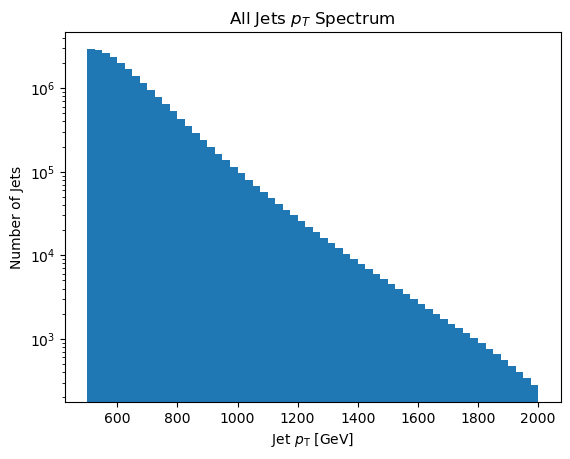

In [12]:
custom_bins = np.linspace(500, 2000, 61)
draw_pt_spectrum(all_jets[:,0], custom_bins, 
                 title = 'All Jets ', user_weights = all_jets[:,7], save = True)

# Flat Pt Distribution

In [15]:
bin_contents, bin_edges = np.histogram(all_jets[:,0], custom_bins, weights = all_jets[:,7])

In [17]:
flat_weight_factor = 1./bin_contents

In [18]:
original_weights = all_jets[:,7].copy()
original_weights = original_weights[:,None]

In [20]:
for i, pt in enumerate(bin_edges[:-1]):
    idx = np.where((all_jets[:,0]>= pt) & (all_jets[:,0]< bin_edges[i+1]))
    all_jets[idx,7] = all_jets[idx,7] * flat_weight_factor[i]


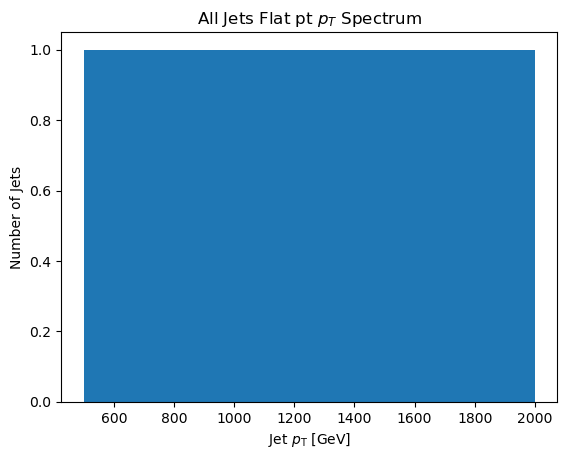

In [21]:
draw_pt_spectrum(all_jets[:,0], custom_bins, use_log=False,
                 title = 'All Jets Flat pt ', user_weights = all_jets[:,7], save = True)

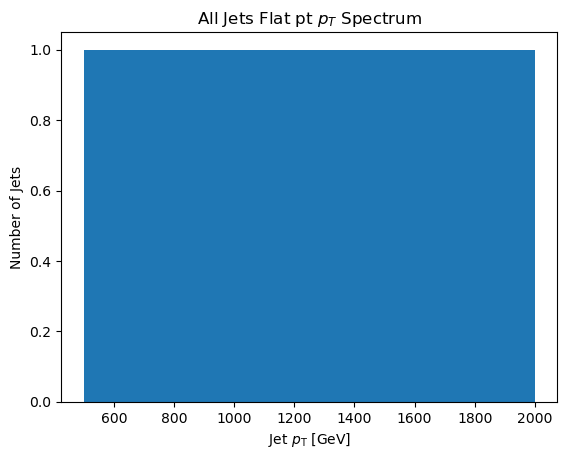

In [22]:
all_jets = np.concatenate((all_jets, original_weights), axis=1)
all_jets[:, [8, 7]] = all_jets[:, [7, 8]]

draw_pt_spectrum(all_jets[:,0], custom_bins, use_log=False,
                 title = 'All Jets Flat pt ', user_weights = all_jets[:,8], save = True)

In [23]:
all_jets.shape

(56414516, 9)

In [27]:
all_jets = all_jets[all_jets[:,6]!= -1]

In [28]:
import pandas as pd 
branch_names = ["jet_pt", "jet_eta", "jet_nTracks", "jet_trackWidth", "jet_trackC1", "jet_trackBDT", "jet_PartonTruthLabelID", "total_weight", "flat_weight"]
df = pd.DataFrame(all_jets, columns = branch_names)

In [76]:
df.to_pickle("./pkls/all_jets_periodA.pkl")

# Small dataset

In [40]:
quark_idx = np.where((all_jets[:,6]==1) | (all_jets[:,6]==2) | (all_jets[:,6]==3) | (all_jets[:,6]==4) | (all_jets[:,6]==5))
quark_jet = all_jets[quark_idx]

gluon_idx = np.where((all_jets[:,6]==21))
gluon_jet = all_jets[gluon_idx]

In [41]:
quark_jet.shape

(31988293, 9)

In [42]:
gluon_jet.shape

(24424285, 9)

In [64]:
nevents = 100000

rng = np.random.default_rng(seed=42)
small_quark = rng.choice(quark_jet, nevents)
small_gluon = rng.choice(gluon_jet, nevents)

In [65]:
X = np.concatenate((small_quark, small_gluon), axis=0)
y = np.concatenate((np.zeros(nevents), 1.0 * np.ones(nevents)))

In [75]:
small_sample = pd.DataFrame(np.concatenate((X, y[:,None]), axis = 1), columns = branch_names + ["target"])
small_sample.to_pickle("./pkls/small_sample_periodA.pkl")

# Small sample distributions

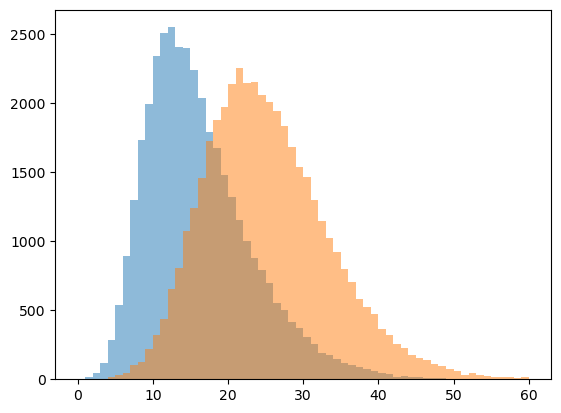

In [66]:
fig, ax = plt.subplots()
bin_edges = np.linspace(0, 60, 61)
ax.hist(X[:nevents][:, 2], bins=bin_edges, weights=X[:nevents][:, 7], alpha = 0.5)
ax.hist(X[nevents:][:, 2], bins=bin_edges, weights=X[nevents:][:, 7], alpha = 0.5)

fig.show()


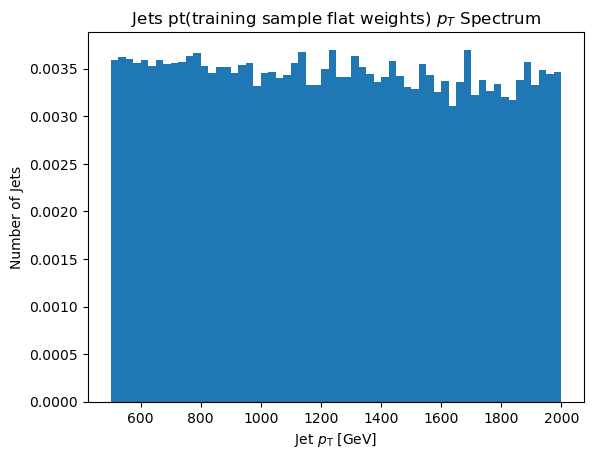

In [93]:
draw_pt_spectrum(X[:,0], custom_bins, use_log=False,
                 title = 'Jets pt(training sample flat weights) ', user_weights = X[:,8], save = True)

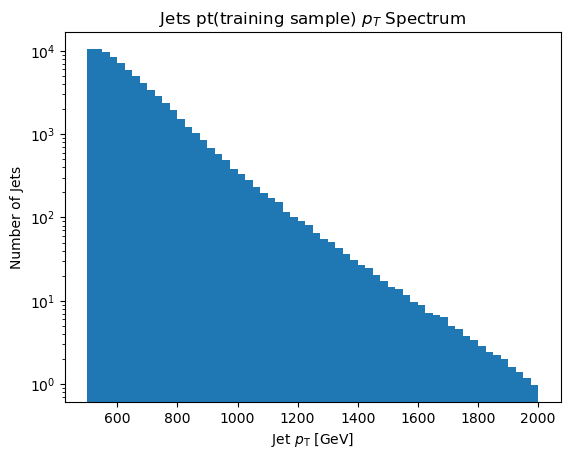

In [94]:
draw_pt_spectrum(X[:,0], custom_bins, use_log=True,
                 title = 'Jets pt(training sample) ', user_weights = X[:,7], save = True)

# Train

In [4]:
file = "/global/cfs/projectdirs/atlas/hrzhao/qgcal/BDT_EB3/pkls/small_sample_periodA.pkl"

small_sample = pd.read_pickle(file)
small_sample_array = small_sample.to_numpy()

assert small_sample_array.shape == (200000, 10)

X = small_sample_array[:, :-1]
y = small_sample_array[:, -1]

In [5]:
from sklearn.model_selection import train_test_split

X_dev,X_eval, y_dev,y_eval = train_test_split(X, y, test_size=0.1, random_state=456)
X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, test_size=0.1/0.9, random_state=789)

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score

dt = DecisionTreeClassifier(max_depth=9,
                            min_samples_leaf=0.001,
                            max_features="log2")
bdt = AdaBoostClassifier(dt,
                         algorithm='SAMME',
                         n_estimators=1000,
                         learning_rate=0.1)

bdt.fit(X_train[:, :5], y_train, sample_weight=X_train[:,8])


AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=9,
                                                         max_features='log2',
                                                         min_samples_leaf=0.001),
                   learning_rate=0.1, n_estimators=1000)

In [7]:
y_test_decisions = bdt.decision_function(X_test[:, :5])

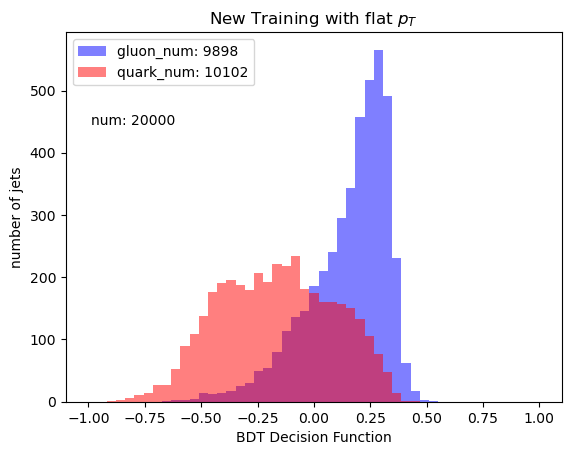

In [8]:
y_test_gluon_id = np.where(y_test==1)[0]
y_test_quark_id = np.where(y_test==0)[0]
bins_scores = np.linspace(-1, 1, 50)
plt.hist(y_test_decisions[y_test_gluon_id], weights=X_test[y_test_gluon_id][:, 7], bins= bins_scores, alpha=0.5, label='gluon'+f"_num: {len(y_test_gluon_id)}", color = 'blue') # add the weights! 
plt.hist(y_test_decisions[y_test_quark_id], weights=X_test[y_test_quark_id][:, 7], bins= bins_scores, alpha=0.5, label='quark'+f"_num: {len(y_test_quark_id)}", color = 'red')
plt.legend(loc='upper left')
plt.text(0.05, 0.75, f"num: {len(X_test)}", transform=plt.gca().transAxes)
plt.xlabel("BDT Decision Function")
plt.ylabel("number of jets")
plt.title(r"New Training with flat $p_{T}$")
plt.savefig("New_Training_flatpt.png", dpi=300)
plt.show()


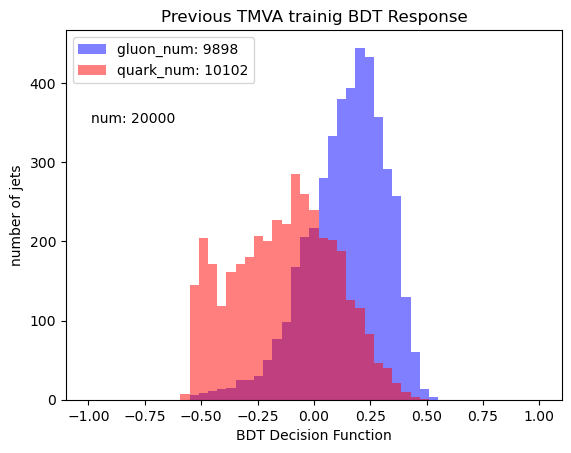

In [12]:
bins_scores_tmva = np.linspace(-1, 1, 50)
plt.hist(X_test[:,-4][y_test_gluon_id], bins_scores_tmva, weights=X_test[:,7][y_test_gluon_id], alpha=0.5, label='gluon'+f"_num: {len(y_test_gluon_id)}", color = 'blue')
plt.hist(X_test[:,-4][y_test_quark_id], bins_scores_tmva, weights=X_test[:,7][y_test_quark_id], alpha=0.5, label='quark'+f"_num: {len(y_test_quark_id)}", color = 'red')
plt.legend(loc='upper left')
plt.text(0.05, 0.75, f"num: {len(X_test)}", transform=plt.gca().transAxes)
plt.xlabel("BDT Decision Function")
plt.ylabel("number of jets")
plt.title("Previous TMVA trainig BDT Response")
plt.show()

In [10]:
from sklearn.metrics import roc_curve, auc

def Draw_ROC_all(y, decisions, y_tmva, y_ntrk, X_weight, features):
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(y, decisions, sample_weight = X_weight)
    fpr_tmva, tpr_tmva, thresholds_tmva = roc_curve(y, y_tmva, sample_weight = X_weight)
    fpr_ntrk, tpr_ntrk, thresholds_ntrk =  roc_curve(y, y_ntrk, sample_weight = X_weight)

    roc_auc = auc(fpr, tpr)
    roc_auc_tmva = auc(fpr_tmva, tpr_tmva)
    roc_auc_ntrk = auc(fpr_ntrk, tpr_ntrk)


    plt.plot(1-fpr, tpr, lw=1, label='ROC_NewTraining (area = %0.3f)'%(roc_auc))
    plt.plot(1-fpr_tmva, tpr_tmva, lw=1, label='ROC_TMVA (area = %0.3f)'%(roc_auc_tmva))
    plt.plot(1-fpr_ntrk, tpr_ntrk, lw=1, label='ROC_Ntrk (area = %0.3f)'%(roc_auc_ntrk))

    plt.plot([0, 1], [1, 0], '--', color=(0.6, 0.6, 0.6), label='Luck')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC with features:{features}'+r" flat $p_{T}$")
    plt.legend(loc="lower left")
    plt.grid()
    plt.show()


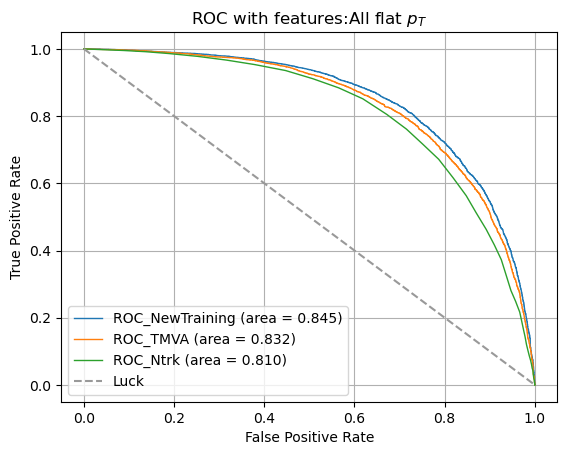

In [11]:
Draw_ROC_all(y_test, y_test_decisions, y_tmva=X_test[:,5] , y_ntrk=X_test[:,2], X_weight=X_test[:, 7], features="All")

In [13]:
import pickle
filename = './models/bdt_model_flat_pt_gridsearchCV.model'
pickle.dump(bdt, open(filename, 'wb'))

# Overtraining test

In [14]:
y_test_decisions = bdt.decision_function(X_test[:, :5])
y_train_decisions = bdt.decision_function(X_train[:, :5])

In [15]:
y_test_decisions_gluon = y_test_decisions[np.where(y_test==1)]
y_test_decisions_quark = y_test_decisions[np.where(y_test==0)]
y_train_decisions_gluon = y_train_decisions[np.where(y_train==1)]
y_train_decisions_quark = y_train_decisions[np.where(y_train==0)]
decisions = []
decisions.append(y_train_decisions_gluon)
decisions.append(y_train_decisions_quark)
decisions.append(y_test_decisions_gluon)
decisions.append(y_test_decisions_quark)

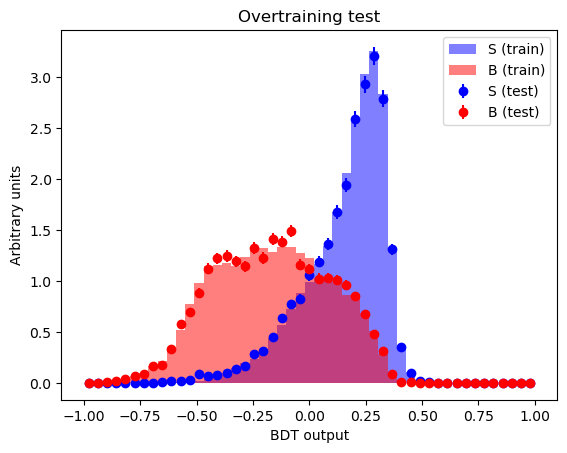

In [16]:
bins=np.linspace(-1, 1, 50)
plt.hist(decisions[0], weights = X_train[:,7][np.where(y_train==1)],
            color='b', alpha=0.5, bins=bins,
            histtype='stepfilled', density=True,
            label='S (train)')
plt.hist(decisions[1], weights = X_train[:,7][np.where(y_train==0)],
            color='r', alpha=0.5,  bins=bins,
            histtype='stepfilled', density=True,
            label='B (train)')

hist, bins = np.histogram(decisions[2], weights=X_test[:,7][np.where(y_test==1)],
                            bins=bins,  density=True)
scale = len(decisions[2]) / sum(hist)
err = np.sqrt(hist * scale) / scale

width = (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='S (test)')

hist, bins = np.histogram(decisions[3], weights=X_test[:,7][np.where(y_test==0)],
                            bins=bins, density=True)
scale = len(decisions[2]) / sum(hist)
err = np.sqrt(hist * scale) / scale

plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='B (test)')

plt.xlabel("BDT output")
plt.ylabel("Arbitrary units")
plt.legend(loc='best')
plt.title("Overtraining test")
plt.savefig("overfitting_test.png",dpi=300)